# https://www.kaggle.com/datasets/fredericksalazar/global-gdp-pib-per-capita-dataset-1960-present

In [1]:
from future.backports.email.feedparser import headerRE

df_path = r"F:\Datasets\CSV datasets\pib_per_capita_countries_dataset.csv"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import great_tables as tg
import datetime as dt
import numpy as np

In [3]:
df = pl.read_csv(df_path)

In [4]:
df = df.with_columns(
    pl.col("intermediate_region").fill_null('UNKNOWN'),
    pl.col('region').fill_null('UNKNOWN'),
    pl.col('gdp_variation').fill_null(0.0)
)

In [8]:
df.select(pl.col('*').unique().count())

country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,gdp_per_capita,gdp_variation
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
215,215,7,17,8,1,1,64,11321,10778


In [13]:
X = df.select(cs.exclude('gdp_per_capita'))

In [16]:
y = df.get_column('gdp_per_capita')

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [42]:
X.select(cs.numeric())

year,gdp_variation
i64,f64
1960,0.0
1961,0.0
1962,0.0
1963,0.0
1964,0.0
…,…
2019,-7.78558
2020,-9.333971
2021,6.611911


In [43]:
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(
            handle_unknown='ignore', sparse_output=False, drop='first'),
         ['country_code', 'country_name', 'region', 'sub_region', 'intermediate_region', 'indicator_code',
          'indicator_name']
         ),
        ('passthrough', 'passthrough', ['year', 'gdp_variation'])
    ]
)

In [44]:
X_encoded = column_transformer.fit_transform(X)

In [45]:
feature_names = column_transformer.named_transformers_['encoder'].get_feature_names_out()

In [53]:
numeric_columns = X.select(cs.numeric()).columns

In [57]:
all_feature_names = list(feature_names) + numeric_columns

In [59]:
X_encoded = pl.DataFrame(X_encoded, schema=list(all_feature_names))

In [60]:
X_encoded

country_code_AFG,country_code_AGO,country_code_ALB,country_code_AND,country_code_ARE,country_code_ARG,country_code_ARM,country_code_ASM,country_code_ATG,country_code_AUS,country_code_AUT,country_code_AZE,country_code_BDI,country_code_BEL,country_code_BEN,country_code_BFA,country_code_BGD,country_code_BGR,country_code_BHR,country_code_BHS,country_code_BIH,country_code_BLR,country_code_BLZ,country_code_BMU,country_code_BOL,country_code_BRA,country_code_BRB,country_code_BRN,country_code_BTN,country_code_BWA,country_code_CAF,country_code_CAN,country_code_CHE,country_code_CHL,country_code_CHN,country_code_CIV,country_code_CMR,…,country_name_VANUATU,country_name_VENEZUELA,country_name_VIET NAM,"country_name_YEMEN, REP. DEL",country_name_ZAMBIA,country_name_ZIMBABWE,region_ASIA MERIDIONAL,region_ASIA ORIENTAL Y EL PACÍFICO (EXCLUIDO ALTOS INGRESOS),region_EUROPA Y ASIA CENTRAL (EXCLUIDO ALTOS INGRESOS),region_ORIENTE MEDIO Y NORTE DE ÁFRICA (EXCLUIDO ALTOS INGRESOS),region_UNKNOWN,region_ÁFRICA AL SUR DEL SAHARA (EXCLUIDO ALTOS INGRESOS),sub_region_CENTRAL ASIA,sub_region_EASTERN ASIA,sub_region_EASTERN EUROPE,sub_region_LATIN AMERICA AND THE CARIBBEAN,sub_region_MELANESIA,sub_region_MICRONESIA,sub_region_NORTHERN AFRICA,sub_region_NORTHERN AMERICA,sub_region_NORTHERN EUROPE,sub_region_POLYNESIA,sub_region_SOUTH-EASTERN ASIA,sub_region_SOUTHERN ASIA,sub_region_SOUTHERN EUROPE,sub_region_SUB-SAHARAN AFRICA,sub_region_WESTERN ASIA,sub_region_WESTERN EUROPE,intermediate_region_CENTRAL AMERICA,intermediate_region_EASTERN AFRICA,intermediate_region_MIDDLE AFRICA,intermediate_region_SOUTH AMERICA,intermediate_region_SOUTHERN AFRICA,intermediate_region_UNKNOWN,intermediate_region_WESTERN AFRICA,year,gdp_variation
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1960.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1961.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1962.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1963.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1964.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2019.0,-7.78558
0.0,0.0,0.0,

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()

In [65]:
scaled_X_train = scaler.fit_transform(X_train)

In [73]:
scaled_X_train = pl.DataFrame(scaled_X_train, schema=X_train.columns)

In [74]:
scaled_X_test = scaler.transform(X_test)

In [76]:
scaled_X_test = pl.DataFrame(scaled_X_test, schema=X_test.columns)

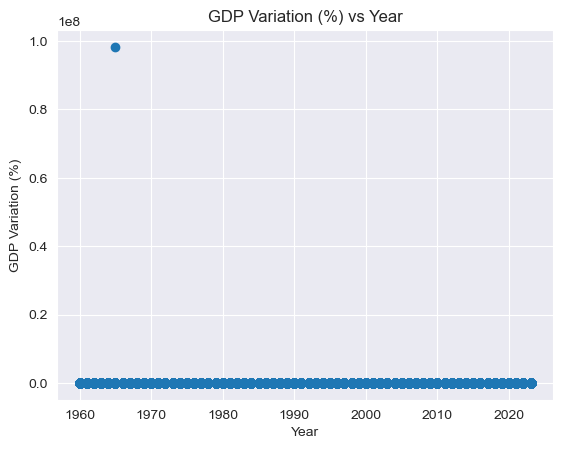

In [79]:
plt.scatter(X['year'], X['gdp_variation'])
plt.xlabel('Year')
plt.ylabel('GDP Variation (%)')
plt.title('GDP Variation (%) vs Year')
plt.show()

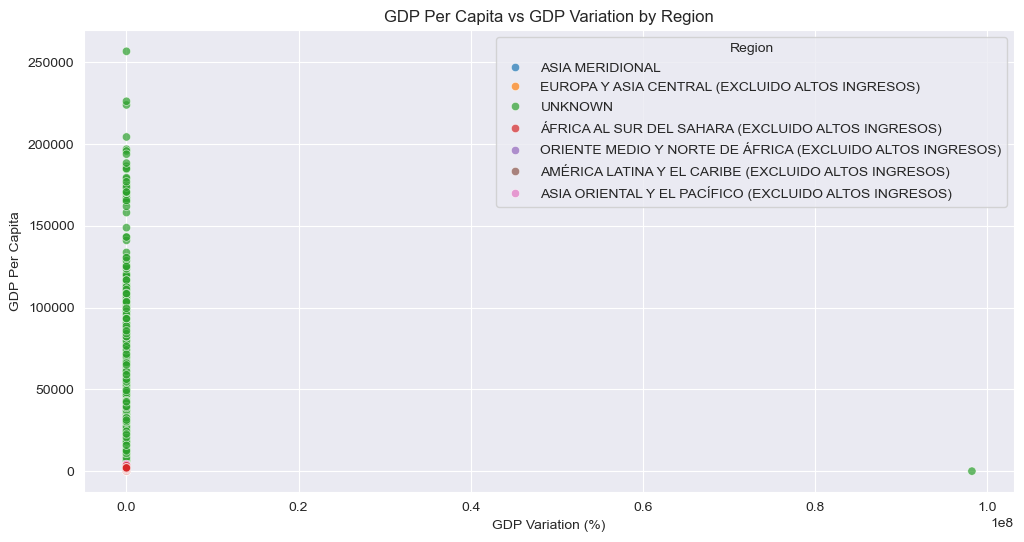

In [89]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="gdp_variation",
    y="gdp_per_capita",
    hue="region",
    alpha=0.7
)
plt.title("GDP Per Capita vs GDP Variation by Region")
plt.xlabel("GDP Variation (%)")
plt.ylabel("GDP Per Capita")
plt.legend(title="Region")
plt.show()

In [84]:
from sklearn.linear_model import LinearRegression

In [90]:
liner_model = LinearRegression(n_jobs=-1)

In [91]:
liner_model.fit(scaled_X_train, y_train)

LinearRegression(n_jobs=-1)

In [93]:
predictions = liner_model.predict(X_test)

In [97]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [99]:
pl.DataFrame({
    'actual': y_test,
    'predicted': predictions,
    'error': (predictions - y_test),
    'error_percent': (predictions - y_test) / y_test,
})

actual,predicted,error,error_percent
f64,f64,f64,f64
213.842543,1.5027e16,1.5027e16,7.0272e13
0.0,4.1170e16,4.1170e16,inf
882.68981,1.5077e16,1.5077e16,1.7080e13
0.0,2.2159e15,2.2159e15,inf
813.789397,9.7856e15,9.7856e15,1.2025e13
…,…,…,…
229.598918,2.2159e15,2.2159e15,9.6513e12
0.0,3.1818e16,3.1818e16,inf
66108.733646,2.6575e16,2.6575e16,4.0199e11


In [110]:
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
percent_error = mean_absolute_percentage_error(y_test, predictions)

In [111]:
percent_error

np.float64(1.7734913216604435e+31)

In [101]:
f'MSE {MSE:.2f}, RMSE {RMSE:.2f}, MAE {MAE:.2f}'

'MSE 753081814043631992337901929103360.00, RMSE 27442336162280936.00, MAE 22997018681965724.00'

In [112]:
results = pl.DataFrame({
    'Error': ['MSE', 'RMSE', 'R2', 'MAE', 'MAPE'],
    'Linera Regression MSE': [MSE, RMSE, R2, MAE, percent_error],
})

In [113]:
results

Error,Linera Regression MSE
str,f64
"""MSE""",7.5308e32
"""RMSE""",2.7442e16
"""R2""",-2.4520e24
"""MAE""",2.2997e16
"""MAPE""",1.7735e31


In [114]:
from sklearn.model_selection import GridSearchCV

In [118]:
liner_reg_parm_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1]
}

In [119]:
grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=liner_reg_parm_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [120]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [-1],
                         'positive': [True, False]},
             verbose=1)

In [122]:
predictions = grid_search.predict(X_test)

In [121]:
pl.DataFrame({
    'actual': y_test,
    'predicted': grid_search.predict(X_test),
    'error': (grid_search.predict(X_test) - y_test),
    'error_percent': (grid_search.predict(X_test) - y_test) / y_test,
})

actual,predicted,error,error_percent
f64,f64,f64,f64
213.842543,3.8893e16,3.8893e16,1.8188e14
0.0,9.8772e15,9.8772e15,inf
882.68981,3.8893e16,3.8893e16,4.4062e13
0.0,1.0174e16,1.0174e16,inf
813.789397,9.7763e15,9.7763e15,1.2013e13
…,…,…,…
229.598918,1.0174e16,1.0174e16,4.4311e13
0.0,2.9411e16,2.9411e16,inf
66108.733646,1.4635e16,1.4635e16,2.2138e11


In [131]:
MSE = mean_squared_error(y_test, grid_search.predict(X_test))
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, grid_search.predict(X_test))
r2 = r2_score(y_test, grid_search.predict(X_test))
percent_error = mean_absolute_percentage_error(y_test, grid_search.predict(X_test))

In [132]:
liner_reg_cv_values = [MSE, RMSE, r2, MAE, percent_error]

In [135]:
results = results.with_columns(pl.Series(
    name='Linera Regression CV', values=liner_reg_cv_values
))

In [137]:
from sklearn.svm import SVR

In [138]:
svm = SVR()

In [150]:
svm_cv_params = {
    'kernel': ['poly'],
    'degree': [1, 2],
    'gamma': ['auto'],
    'epsilon': [0.1, 0.5, 1],
}

In [151]:
svr_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=svm_cv_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [152]:
svr_grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Zygim\anaconda3\envs\Analytics__2024_12_29\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2], 'epsilon': [0.1, 0.5, 1],
                         'gamma': ['auto'], 'kernel': ['poly']},
             verbose=1)

In [153]:
svr_grid_search.predict(X_test)

array([24940.76460064, 24976.85551452, 25493.25941331, ...,
       25524.81352308, 25443.8396864 , 25280.09022974], shape=(2752,))

In [154]:
MSE = mean_squared_error(y_test, svr_grid_search.predict(X_test))
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, svr_grid_search.predict(X_test))
r2 = r2_score(y_test, svr_grid_search.predict(X_test))
percent_error = mean_absolute_percentage_error(y_test, svr_grid_search.predict(X_test))

In [155]:
results.with_columns(
    pl.Series(name='SVR CV', values=[MSE, RMSE, r2, MAE, percent_error])
)

Error,Linera Regression MSE,Linera Regression CV,SVR CV
str,f64,f64,f64
"""MSE""",7.5308e32,3.2185e32,6.0393e8
"""RMSE""",2.7442e16,1.7940e16,24575.042901
"""R2""",-2.4520e24,-1.0480e24,-0.966408
"""MAE""",2.2997e16,1.5833e16,22213.337788
"""MAPE""",1.7735e31,1.1623e31,1.9694e19
